# Taking pre-trained VGG model

In [3]:
%%capture
%reload_ext autoreload
%autoreload 2
from codedetails import *

## Download pre-trained VGG16 model (16-layer deep Convolutional Neural Network)
##### VGG16 is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it.

In [9]:
download_pretrained_model()

In [10]:
load_and_preprocess_test_image("./tiger.jpg")

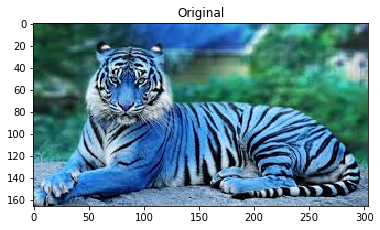

In [11]:
display_image("Original")

In [12]:
predict_image_object()


Predicted class: tiger with probability 74.73


In [13]:
apply_grad_cam()

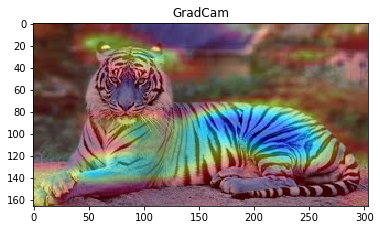

In [14]:
display_image("GradCam")